## Chapter 16.1 Sentiment Analysis and the Dataset

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [4]:
def read_imdb(data_dir, is_train):
    """Read the IMDB review dataset text sequences and labels."""
    
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels
    
train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))

for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: I saw this movie as a teenager and immediately identified wi
label: 1 review: ...On stage, TV or in a book, 'The Woman in Black' is an out
label: 1 review: Does anyone know what kind of pickup John T drove? I looks l


In [5]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

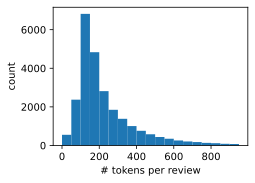

In [6]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [7]:
num_steps = 500 # of sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [8]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [9]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False)
    
    return train_iter, test_iter, vocab

## Chapter 16.2 Sentiment Analysis: Using Recurrent Neural Networks

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [14]:
class BiRNN(nn.Module):
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        
        return outs
    

In [15]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
                
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [16]:
# Loading Pretrained Word Vectors

glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [17]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [18]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.277, train acc 0.886, test acc 0.857
1416.0 examples/sec on [device(type='cuda', index=0)]


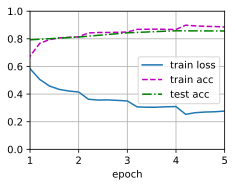

In [19]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [20]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [21]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [22]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

* Pretrained word vectors can represent individual tokens in a text sequence.

* Bidirectional RNNs can represent a text sequence, such as via the concatenation of its hidden states at the initial and final time steps. This single text representation can be transformed into categories using a fully connected layer.

## Chapter 16.3 Sentiment Analysis: Using Convolutional Neural

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [26]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i+w] * K).sum()
    return Y

In [27]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [28]:
def corr1d_multi_in(X, K):
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
                 [1, 2, 3, 4, 5, 6, 7],
                 [2, 3, 4, 5, 6, 7, 8]])

K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

In [29]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))
            
    def forward(self, inputs):
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        
        embeddings = embeddings.permute(0, 2, 1)
        
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        
        outputs = self.decoder(self.dropout(encoding))
        
        return outputs

In [30]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)
        
net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49346, 100)
  (constant_embedding): Embedding(49346, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [31]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

loss 0.065, train acc 0.979, test acc 0.872
2944.9 examples/sec on [device(type='cuda', index=0)]


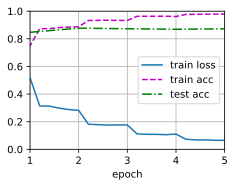

In [32]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [33]:
d2l.predict_sentiment(net, vocab, 'this movie is so greate')

'positive'

In [34]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

* One-dimensional CNNs can process local features such as n-grams in text.

* Multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations.

* The max-over-time pooling allows different numbers of time steps at different channels.

* The textCNN model transforms individual token representations into downstream application outputs using one-dimensional convolutional layers and max-over-time pooling layers.

## Chapter 16.4 Natural Language Inference and the Dataset

In [35]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

In [36]:
d2l.DATA_HUB['SNLI'] = ('https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [ ]:
def read_snli(data_dir, is_train):
    